# Johnstone Strait Boundary Conditions, following Debby's algorithm

30 June 2025 DI
Algorithm to determine DIC and TA at the Johnstone St boundary
#############################################################
- each step includes background information necessary for publication (I hope :) 

In [90]:
import arrow
import datetime
import gsw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PyCO2SYS as pyco2
import xarray as xr

### Required Function, Pressure from SA and CT ###
Note that the problem is circular, we have depth that we will use as pressure, then. 
calculate the density, update the pressure.  One could iterate but the initial corrected pressure is
within 0.002 dbar of the next iteration

In [91]:
def pressure_from_SA_and_CT(SA, CT, depth):
    g = 9.81
    pressure = np.array(depth)
    in_situ_density = gsw.density.rho(SA[:, :, 0, 0], 
                                   CT[:, :, 0, 0], pressure).mean(axis=0)
    pressure[0] = (g * in_situ_density[0] * depth[0]) / 1e4
    for iz in range(1, 40):
        pressure[iz] = pressure[iz-1] + (g * (
            in_situ_density[iz] + in_situ_density[iz-1]) * 0.5 *
            (depth[iz] - depth[iz-1])) / 1e4


    # Above is fine and makes sense but I need an array that matches 
    # the shape of the rest of the arrays, aka, t, z, y, x
    [lt, lz, ly, lx] = bc_phys.vosaline.values.shape
    pressure_t = np.tile(pressure, (lt, 1)).transpose()
    pressure_ty = np.tile(pressure_t, (ly, 1, 1))
    pressure_tzyx = np.tile(pressure_ty, (lx, 1, 1, 1)).transpose()
    
    new_pressure = xr.DataArray(pressure_tzyx, coords=SA.coords,
                                attrs= {'long_name': 'Pressure',
                                            'units': 'dbar'})
    return new_pressure

### Step One ###

(1) read date(t), salinity(SA), temperature(CT) depth (z), (nutrients?) at JS boundary  
    - could read atmospheric pCO2 here too if easy, else calculate it in step (3)

In [92]:
# 1) Choose Base Date 
date = datetime.datetime(2015, 8, 1, 0, 0, 0)
# Read salinity, temperature, depth
bc_phys = xr.open_dataset('/home/sallen/MEOPAR/tracers/north/Dosser_north_TEOS10.nc')
# This is a 12-month climatology, varying with month and depth but uniform horizontally.
bc_bio = xr.open_dataset('/home/sallen/MEOPAR/tracers/north/bioOBC_North_monthlySiNO3.nc')
# Same structure

### Step Two ###
(2) convert units (as necessary). 
    (a) model salinity (SA) to practical salinity (S) (because pyco2sys requires S)  
    (b) conservative temperature to (T)   
    (c) z to pressure (P)   
    (d) nutrients (iff used in pyco2sys calc) to umol/kg  
 after this point all units are 'observationalist' units - convert to model units at the very end of algorithm

In [93]:
# 2) Unit Conversions
# Calculate density
bc_phys['potential_density'] = gsw.density.rho(bc_phys.vosaline, bc_phys.votemper, 0)
bc_phys.potential_density.attrs['long_name'] = 'Potential Density'
bc_phys.potential_density.attrs['units'] = 'kg/m3'

In [94]:
# Calculate practical salinity
bc_phys['practical_salinity'] = gsw.conversions.SP_from_SA(bc_phys.vosaline, bc_phys.deptht,
                                                           lon=-126.19, lat=50.48)

bc_phys.practical_salinity.attrs['long_name'] = 'Practical salinity'
bc_phys.practical_salinity.attrs['units'] = 'None'

In [95]:
# Calculate Potential Temperature
bc_phys['potential_temperature'] = gsw.conversions.pt_from_CT(bc_phys.vosaline, bc_phys.votemper)

bc_phys.potential_temperature.attrs['long_name'] = 'Potential temperature'
bc_phys.potential_temperature.attrs['units'] = 'oC'

In [126]:
# Calculate Pressure
bc_phys['pressure'] = pressure_from_SA_and_CT(bc_phys.vosaline, bc_phys.votemper, bc_phys.deptht)

In [97]:
# Convert nutrients to umol/kg 
# Note, we use potential density here as model is incompressible
bc_bio['NO3_per_kg'] = (bc_bio.NO3 / bc_phys.potential_density # (mmol/m3 / kg/m3 -> mmol/kg)
                        * 1000) #mmol/kg * 1000 umol/mmol

bc_bio.NO3_per_kg.attrs['long_name'] = 'Nitrate per unit mass'
bc_bio.NO3_per_kg.attrs['units'] = 'umol/kg'

bc_bio['Si_per_kg'] = (bc_bio.Si / bc_phys.potential_density # (mmol/m3 / kg/m3 -> mmol/kg)
                        * 1000) #mmol/kg * 1000 umol/mmol

bc_bio.Si_per_kg.attrs['long_name'] = 'dissolved Silicon per unit mass'
bc_bio.Si_per_kg.attrs['units'] = 'umol/kg'

### Step Three ###
(3) determine PCO2 atmosphere = f(time) 
     - use TJ's equations for seasonal cycle and annual mean
     - I did not write python code - made estimates for local pCO2 on the two days needed (and used 284uatm for preind quick calc)

##### Fortran code pasted here - from SEA 24-June-2025 email:
z_day = nday_year

      zz_yearcyc =  zz_amp * exp( -((zz_day - zz_ctr)/zz_wid)**2)&
              + zz_amp2 * exp( -((zz_day - zz_ctr2)/zz_wid2)**2)&
              + zz_amp3 * exp( -((zz_day - zz_ctr3)/zz_wid3)**2)

      zz_atcco2 = (zz_year+(zz_day/365))*zz_LR_slope+zz_LR_int + zz_yearcyc

where nday_year is the year day,

       zz_year is the year (aka 2025)
       zz_LR_slope   =  2.149     !  linear regression + gaussian fit 
       zz_LR_int     =  -3929.359 !  to seasonal cycle of atmospheric co2
       zz_ctr        =  161.898   !  based on scripps observations at ptbarrow and lajolla
       zz_amp        =  7.083     !  calc notebook by TJSJ
       zz_wid        =  44.703    !  notebook loc:
       zz_ctr2       =  218.832   !  carbon_dev/MOCSY_and_FLUX/CO2_obs.ipynb
       zz_amp2       =  -19.004   !
       zz_wid2       =  87.8836   !
       zz_ctr3       =  199.430   !
       zz_amp3       =  8.026     !
       zz_wid3       =  -185.920  !

## Update ##

Don't use the seasonal cycle as, at least the deep water, won't be in equilibrium with the current month.

In [98]:
# constants
zz_LR_slope   =  2.149     #  linear regression + gaussian fit 
zz_LR_int     =  -3929.359 #  to seasonal cycle of atmospheric co2
zz_ctr        =  161.898   #  based on scripps observations at ptbarrow and lajolla
zz_amp        =  7.083     #  calc notebook by TJSJ
zz_wid        =  44.703    #  notebook loc:
zz_ctr2       =  218.832   #  carbon_dev/MOCSY_and_FLUX/CO2_obs.ipynb
zz_amp2       =  -19.004   #
zz_wid2       =  87.8836   #
zz_ctr3       =  199.430   #
zz_amp3       =  8.026     #
zz_wid3       =  -185.920  #

In [99]:
# if year is before 2000, use data instead
co2_rec = pd.read_csv('../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/lawdome_maunaloa.csv')

In [100]:
zz_year = date.year

In [101]:
# days are center of each month
zz_day = np.zeros((12))
for it, month in enumerate(bc_phys.time_counter.values):
    zz_day_1 = datetime.datetime(zz_year, int(month), 1)
    if month < 12:
        zz_day_Ep1 = datetime.datetime(zz_year, int(month)+1, 1)
        zz_day[it] = 0.5 * (zz_day_1.timetuple().tm_yday + zz_day_Ep1.timetuple().tm_yday - 1)
    else:
        zz_day_E = datetime.datetime(zz_year, 12, 31)
        zz_day[it] = 0.5 * (zz_day_1.timetuple().tm_yday + zz_day_E.timetuple().tm_yday)

In [102]:
#zz_yearcyc = ( zz_amp * np.exp( -((zz_day - zz_ctr)/zz_wid)**2) 
#              + zz_amp2 * np. exp( -((zz_day - zz_ctr2)/zz_wid2)**2) 
#              + zz_amp3 * np.exp( -((zz_day - zz_ctr3)/zz_wid3)**2)
#             )
if zz_year > 2000:
    zz_atcco2 = (zz_year + (zz_day / 365)) *zz_LR_slope + zz_LR_int #+ zz_yearcyc
else:
    zz_atcco2 = co2_rec.PPMCO2[co2_rec.YEAR == zz_year].item() * np.ones((12))
zz_atcco2

array([400.97020274, 401.14388904, 401.31757534, 401.49714932,
       401.67672329, 401.85629726, 402.03587123, 402.21838904,
       402.39796301, 402.57753699, 402.75711096, 402.93668493])

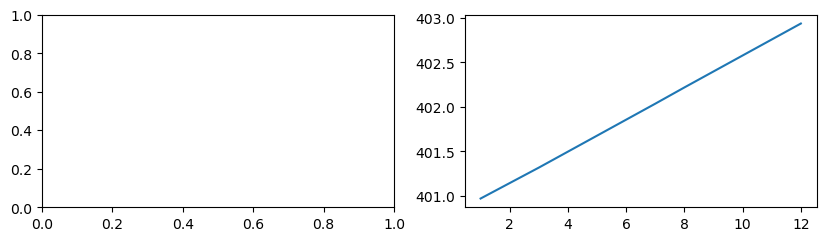

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))
#axs[0].plot(np.arange(1, 13), zz_yearcyc);
axs[1].plot(np.arange(1, 13), zz_atcco2);

In [104]:
#bc_phys['zz_atcco2'] = xr.DataArray(zz_atcco2, coords={"time_counter": bc_phys.time_counter},
#                                   attrs={"long_name": "pCO2 of the atmosphere",
#                                          "units": 'uatm'})

# Above is fine and makes sense but I need an array that matches 
# the shape of the rest of the arrays, aka, t, z, y, x
print (bc_phys.vosaline.values.shape)
[lz, ly, lx] = bc_phys.vosaline.values.shape[1:]
zz_atcco2_z = np.tile(zz_atcco2, (lz, 1))
zz_atcco2_zy = np.tile(zz_atcco2_z, (ly, 1, 1))
zz_atcco2_zyx = np.tile(zz_atcco2_zy, (lx, 1, 1, 1)).transpose()
print (zz_atcco2_zyx.shape)

bc_phys['zz_atcco2'] = xr.DataArray(zz_atcco2_zyx, coords={"time_counter": bc_phys.time_counter,
                                                      "deptht": bc_phys.deptht,
                                                      "yb": bc_phys.yb,
                                                      "xbT": bc_phys.xbT},
                                   attrs={"long_name": "pCO2 of the atmosphere",
                                          "units": 'uatm'})

(12, 40, 10, 30)
(12, 40, 10, 30)


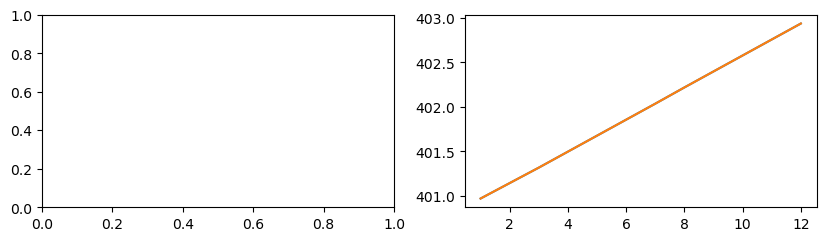

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))
#axs[0].plot(np.arange(1, 13), zz_yearcyc);
axs[1].plot(np.arange(1, 13), zz_atcco2);
axs[1].plot(np.arange(1, 13), bc_phys.zz_atcco2[:, 5, 2, 7]);

### Step 4 ###

(4) determine total alkalinity (ts) at JS boundary - ta_js=f(S)

S = practical salinity - as observed. 
SA = absolute salinity (g/kg): mentioned here  
ta_js was determined from a  linear regression ta=f(S) from all observations with qf of 2 or 6 from 
two available casts where dic and ta were measured.  
-spring 2018 LaPerouse (cruise_ID 2018-39, not yet published) and  
-fall 2019 LaPerouse (cruise 2019-23, published in OCADS and water properties - di to doubleCHECK). 
-ta_js regression was compared with the ta_sog=f(S) regression from the full dataset published in Ianson et al. 2016 GRL. 
(including all regions, i.e. JdF) and the ta-emp=f(S,longitude) regression for P4 published in Franco et al. 2021 GBC.  
ta is higher in the SoG than offshore and (as expected) the JS regression lies between the two.  At lower S the JS 
regression is closer to the SoG regression.  At high S the JS regression is close to the P4 regression.  

ta_js = 43.06*S + 772.71 units umol/kg. 

#####including here code lines with all of the TA-S relationships so that there is no ambiguity. 
##### ta-tj is the TA-SA relationship used by Tereza; others defined above. 
        df = df.with_columns(. 
               (43.06*pl.col("S") + 772.71).alias("ta_js"),  
               (46.82*pl.col("S") + 667.44).alias("ta_sog"),  
               (57.1*pl.col("S") -0.537*(-126.67) + 251.53).alias("ta-emp"),  
               ((42.624*pl.col("SA") + 835.5069)*1000/pl.col("dens")).alias("ta-tj"),  
        )
#####

In [106]:
ta_slope = 43.06
ta_const = 772.71
bc_phys['ta_js'] = bc_phys.practical_salinity * ta_slope + ta_const
bc_phys.ta_js.attrs['long_name'] = 'Total alkalinity js linear regression'
bc_phys.ta_js.attrs['units'] = 'umol/kg'

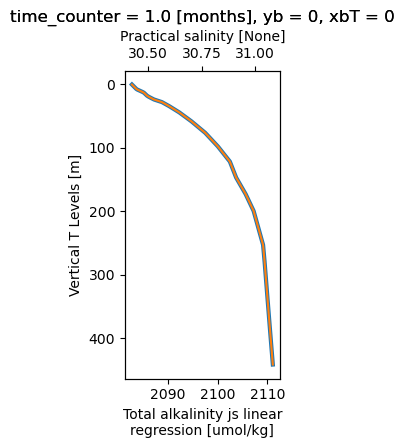

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
bc_phys.ta_js[0, :, 0, 0].plot(ax=ax, y='deptht', yincrease=False, linewidth=3)
ax2 = ax.twiny()
bc_phys.practical_salinity[0, :, 0, 0].plot(ax=ax2, y='deptht', yincrease=False, color='tab:orange');

### Step 5 ###
determine the dissolved inorganic carbon at each depth if ocean pCO2 at that depth were equal to atmsopheric pCO2
on that day (dic_eqm) using pyco2sys: dic_eqm is a function of all input variables (SA, CT, z, time) 
{I am assuming that nutrients will not be used in pyco2sys - function will use default values - if using nutrients add}
Thus dic_eqm is calculated input S,T,TA,pCO2a 

####my code
    #### determine carbonate system with a dic at eqm with atmosphere
    
    kwargs = {
        "salinity": df["S"],  # Salinity of the sample --pracical salinitypsu
        "temperature": df["T"],  # Temperature at input conditions -- degC
        "pressure": df["P"],  # Pressure, dic and ta collected at  -- dbar
        "total_silicate": df["si_kg"],  # Concentration of silicate  in the sample (in umol/kg)
        "total_phosphate": df["po4_kg"],  # Concentration of phosphate in the sample (in umol/kg)
        "opt_k_carbonic": 14,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
        "opt_k_bisulfate": 1,  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")
    }
    
    results_eq = pyco2.sys(
        par1 = df["ta-js"],
        par1_type = 1,         # TA - using ta-js rel (umol/kg) 
        par2 = df["pCO2a"],
        par2_type = 4,         # pCO2 - pCO2 atmosphere (uatm)
        **kwargs
    )
####

**Important** Use the same parameters as Debby used to calculate disequilibrium!

So remove the last three parameters.

In [108]:
kwargs = dict(
    par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
    par1 = bc_phys.ta_js.values,  # value of the first parameter
    par2_type = 4,  # The second parameter supplied is of type "4", which means "pCO2"
    par2 = bc_phys.zz_atcco2.values,
    salinity = bc_phys.practical_salinity.values,  # Salinity of the sample
    temperature = bc_phys.potential_temperature.values,  # Temperature at input conditions 
    pressure = bc_phys.pressure.values, # pressure that dic and ta are at
    total_silicate = bc_bio.Si_per_kg.values,  # Concentration of silicate  in the sample (in umol/kg)
    total_phosphate = bc_bio.NO3_per_kg.values * 1/16.,  # Concentration of phosphate in the sample (in umol/kg)
    opt_k_carbonic = 14,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("14" means Millero 2010")
                          # I checked this in the code
    opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4 ("1" means "Dickson")
#    opt_total_borate = 2,  # Choice of boron:sal ("2" means "LKB10"). # Lee et al what Mucci
#    opt_k_fluoride = 1,
#    opt_pressured_kCO2 = 1
)
print('Conditions have been defined!')

Conditions have been defined!


In [109]:
print (bc_phys.ta_js.values.shape)
print (bc_phys.zz_atcco2.values.shape)
print (bc_phys.practical_salinity.values.shape)
print (bc_phys.potential_temperature.values.shape)
print (bc_phys.pressure.values.shape)

(12, 40, 10, 30)
(12, 40, 10, 30)
(12, 40, 10, 30)
(12, 40, 10, 30)
(12, 40, 10, 30)


In [110]:
results = pyco2.sys(**kwargs)

In [111]:
bc_phys['DIC_equ'] = xr.DataArray(results['dic'],  coords={"time_counter": bc_phys.time_counter,
                                                        "deptht": bc_phys.deptht,
                                                      "yb": bc_phys.yb,
                                                      "xbT": bc_phys.xbT},
                                   attrs={"long_name": "DIC if in Equilibrium with that days's pCO2",
                                          "units": 'umol/kg'})

<xarray.DataArray 'DIC_equ' ()>
array(1956.24656801)
Coordinates:
    deptht        float32 1.5
    time_counter  float32 1.0
    yb            int64 0
    xbT           int64 0
Attributes:
    long_name:  DIC if in Equilibrium with that days's pCO2
    units:      umol/kg


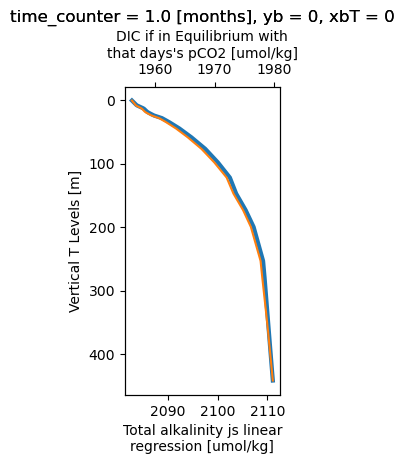

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
bc_phys.ta_js[0, :, 0, 0].plot(ax=ax, y='deptht', yincrease=False, linewidth=3)
ax2 = ax.twiny()
bc_phys.DIC_equ[0, :, 0, 0].plot(ax=ax2, y='deptht', yincrease=False, color='tab:orange');
print (bc_phys.DIC_equ[0, 1, 0, 0])

### Step 6 ###

determine the salinity at z=50m (S_50)

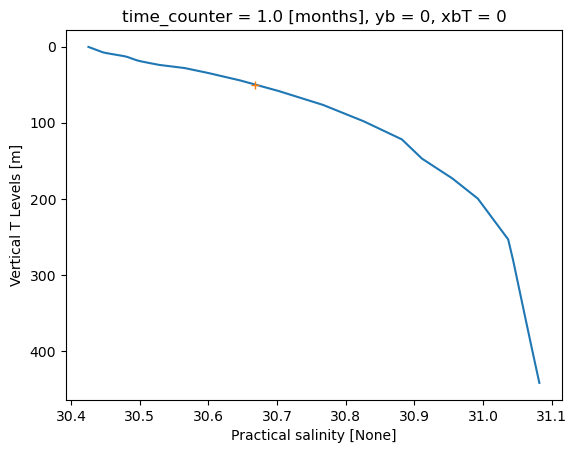

In [113]:
w24 = (50 - bc_phys.deptht[23]) / (bc_phys.deptht[24] - bc_phys.deptht[23])
w23 = (bc_phys.deptht[24] - 50) / (bc_phys.deptht[24] - bc_phys.deptht[23])
#print (w23, bc_phys.deptht[23])
#print (w24, bc_phys.deptht[24])
bc_phys['practical_salinity_at_50m'] = (w23 * bc_phys.practical_salinity[:, 23] + 
                                        w24 * bc_phys.practical_salinity[:, 24])
bc_phys.practical_salinity_at_50m.attrs['long_name'] = 'Practical salinity at 50 m depth'
bc_phys.practical_salinity_at_50m.attrs['units'] = 'None'
#print (bc_phys.practical_salinity_at_50m)
(bc_phys.practical_salinity[0, :, 0, 0]).plot(y='deptht', yincrease=False)
plt.plot(bc_phys.practical_salinity_at_50m[0, 0, 0], 50, '+');

### Step 7 ###

(7) determine dissolved inorganic carbon (dic_diseq) at each depth at the JS boundary - dic_diseq=f(z,S) 
       - here we assume that the dic_disequilibrium (dic_diseq) with the atmosphere is the same throughtout time
       - the method is called the 'delta-dic' method, developed for determining the anthropogenic dic intrusion since preindustrial time (delta-dic)   
       - here we use the same assumptions - that dis-diseq is constant in time in general (model time)  
         not just preindustrial time (the citation for this assumption would be  'us')  
       - the citation for the assumption wrt pre-industrial is: (Matsumoto & Gruber 2005;Pacella et al.2018)  
       - we don't estimate a 'delta-dic' because we don't define a 'present-day' reference point. 
       - see para1 in 2.5 Simpson et al. 2022 for more mechanistic explanation   

{set dic_diseq relationships using two observational casts (2018-39 and 2019-23) DI to ensure data are posted 
on waterproperties and ocads before this paper is accepted - if there are any issues we can post these data with the publication in the sup material for this paper}

HERE - new addition (22 July 2025)

    if (S =< 30.7) then dic_diseq = 35.609  (constant minimum - so we don't extrapolate outside 
                                         of obs-sal-range and model surface is never undersat wrt PCO2
                                         - in winter salinities are fresher than our spring/fall obs)
    elseif (S > 30.7) & (z =< 50) (linear zone) then dic_diseq = 116.009*S - 3525.867  (umol/kg)
    else 
    dic_diseq (constant at the z=50m value) = 116.009*S_50 - 3525.867  (umol/kg)

#### begin my code - "dic_diseq_emp" is dic_diseq empirical... here for both observational casts 
    #no elegance in determining the S_50 in my code - hardwired :)
    df_50 = df.filter(
                  (pl.col("P") < 54) &
                  (pl.col("ta-qf").is_in([2,6])) &
                  (pl.col("dic-qf").is_in([2,6]))
            )
    
    
    slope_diseq, intercept_diseq, r_valued, p_valued, std_errd = sci.stats.linregress(df_50["S"],df_50["dic_diseq"])
    print("slope_diseq, intercept_diseq", slope_diseq, intercept_diseq)
    #116.96176529162793 -3557.785611513509 #without TA filter
    #116.00869265649922 -3525.867327663529 #with TA filter
    #116.00869265649922 -3525.867327663529 #with TA and DIC filter, the only bad DIC are deeper than 50m
    
    #HERE the constant values (for depths below 50m) are set to S_50 read rom the data-file, measured at 50.1 and 49.9m, respectively
    dic_de50_2019 = (116.009*31.4865 - 3525.867)
    dic_de50_2018 = (116.009*30.8599 - 3525.867)
    
    df = df.with_columns(
           (116.009*pl.col("S") - 3525.867).alias("dic_diseq_lin"),
           pl.when(pl.col("crid") == 2019.023).then(dic_de50_2019).otherwise(dic_de50_2018).alias("dic_diseq_constant"),
    )
    
    df = df.with_columns(
        pl.when(pl.col("P") < 54).then(pl.col("dic_diseq_lin")).otherwise(pl.col("dic_diseq_constant")).alias("dic_diseq_emp"),
)
######end my code

In [114]:
bc_phys['DIC_DisEq'] = xr.DataArray(116.009 * bc_phys.practical_salinity - 3525.867,
                                coords={"time_counter": bc_phys.time_counter,
                                                        "deptht": bc_phys.deptht,
                                                      "yb": bc_phys.yb,
                                                      "xbT": bc_phys.xbT},
                                   attrs={"long_name": "Disequilibrium DIC parameterized from data",
                                          "units": 'umol/kg'})
bc_phys['DIC_DisEq'][:, bc_phys.deptht > 50] = 116.009 * bc_phys.practical_salinity_at_50m - 3525.867
bc_phys.DIC_DisEq.values[bc_phys.DIC_DisEq.values < 35.609] = 35.609

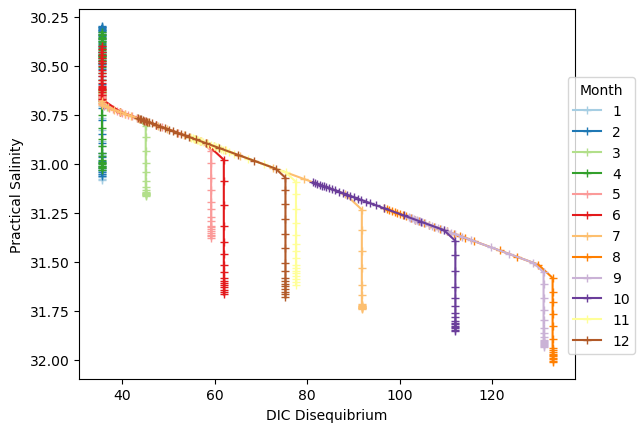

In [115]:
fig, ax = plt.subplots(1, 1)
cmap_lines = plt.get_cmap('Paired')
for ii in range(12):
    ax.plot(bc_phys.DIC_DisEq[ii, :, 0, 0], bc_phys.practical_salinity[ii, :, 0, 0], '+-', 
            label=f'{ii+1}', color=cmap_lines(ii))
ax.invert_yaxis()
ax.set_ylabel('Practical Salinity')
ax.set_xlabel('DIC Disequibrium')
fig.legend(loc='outside right', title="Month");

<xarray.DataArray 'DIC_DisEq' ()>
array(35.609)


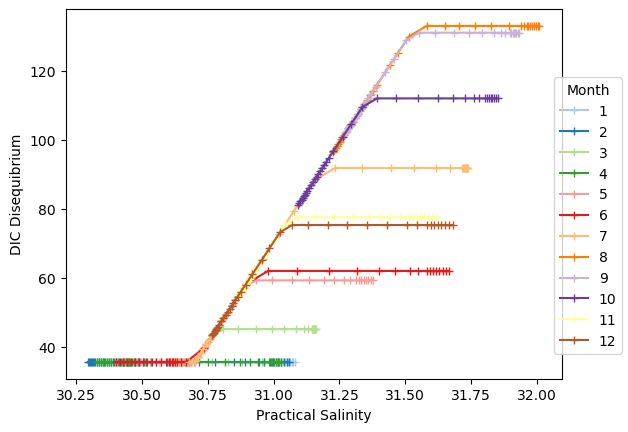

In [116]:
fig, ax = plt.subplots(1, 1)
cmap_lines = plt.get_cmap('Paired')
for ii in range(12):
    ax.plot(bc_phys.practical_salinity[ii, :, 0, 0], bc_phys.DIC_DisEq[ii, :, 0, 0], '+-', 
            label=f'{ii+1}', color=cmap_lines(ii))
ax.set_xlabel('Practical Salinity')
ax.set_ylabel('DIC Disequibrium')
fig.legend(loc='outside right', title="Month");
print (bc_phys.DIC_DisEq[:].min())

### STEP 8 ###

(8) determine dissolved inorganic carbon (dic) at each depth at the JS boundary - dic_js=f(z,S)

dic_js = dic_eq(from algorithm step-5) + dic_diseq(from algorithm step-7)

In [117]:
bc_phys['DIC_JS'] = xr.DataArray(bc_phys.DIC_equ + bc_phys.DIC_DisEq, coords={"time_counter": bc_phys.time_counter,
                                                        "deptht": bc_phys.deptht,
                                                      "yb": bc_phys.yb,
                                                      "xbT": bc_phys.xbT},
                                   attrs={"long_name": f'Johnstone Strait DIC for {date.year}',
                                          "units": 'umol/kg'})

31.824583716051883 2109.798534711843


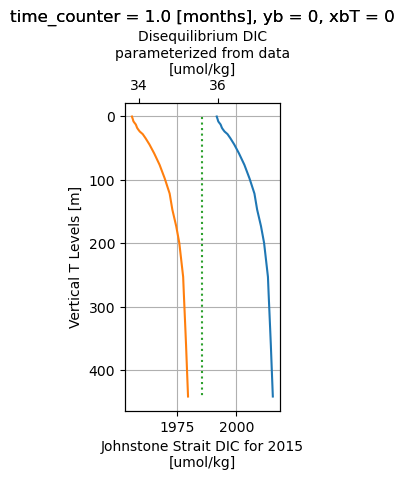

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
bc_phys.DIC_equ[0, :, 0, 0].plot(ax=ax, y='deptht', yincrease=False, color='tab:orange');
ax2 = ax.twiny()
bc_phys.DIC_DisEq[0, :, 0, 0].plot(ax=ax2, y='deptht', yincrease=False, color='tab:green', linestyle=':');
bc_phys.DIC_JS[0, :, 0, 0].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue');
print (bc_phys.practical_salinity[date.month+1, 35, 0, 0].values, bc_phys.DIC_JS[date.month+1, 35, 0, 0].values)
ax.grid();

## Step 9 ### 
(9) Convert dic and ta from observational to model units
(umol/kg to uM)


In [119]:
bc_phys['DIC_JS_uMol'] = xr.DataArray(bc_phys.DIC_JS * bc_phys.potential_density / 1000, 
                                      coords=bc_phys.DIC_JS.coords,
                                   attrs={"long_name": f'Johnstone Strait DIC in uMol for {date.year}',
                                          "units": 'mmol/m3'})

In [120]:
bc_phys['TA_JS_uMol'] = xr.DataArray(bc_phys.ta_js * bc_phys.potential_density / 1000, 
                                      coords=bc_phys.ta_js.coords,
                                   attrs={"long_name": f'Johnstone Strait TA in uMol for {date.year}',
                                          "units": 'mmol/m3'})

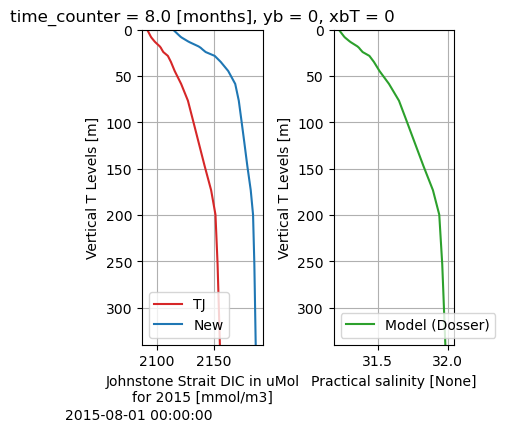

In [121]:
# Compare to Tereza
fig, axs = plt.subplots(1, 2, figsize=(4.5, 4.5))
if date.year > 1950:
    bc_chem = xr.open_dataset('/home/sallen/MEOPAR/tracers/north/Dosser_north_TEOS10_DICTA.nc')
    bc_chem.DIC[date.month-1, :, 0, 0].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:red', label='TJ');
else:
    bc_chem = xr.open_dataset('/home/sallen/MEOPAR/ANALYSIS/analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/preind_DIC/JS_diseq_preind_DIC_allup.nc',
                         group='preindustrial_DIC') 
    axs[0].plot(bc_chem.preind_dic[date.month-1, :, 0, 0], bc_phys.deptht, color='tab:red', label='TJ')
#

bc_phys.DIC_JS_uMol[date.month-1, :, 0, 0].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:blue', label='New');
bc_phys.practical_salinity[date.month-1, :, 0, 0].plot(ax=axs[1], y='deptht', yincrease=False, color='tab:green', label='Model (Dosser)');
for ax in axs:
    ax.legend();
    ax.grid();
    ax.set_ylim(340, 0)
axs[0].text(2020, 420, f'{date}');
axs[1].set_title('')
fig.tight_layout();

### Generate Flat Files ###

In [122]:
for time_counter in range(12):
    monthly = bc_phys.isel(time_counter=time_counter, yb=0, xbT=0)
    monthly.to_pandas().to_csv(f'flat_monthly_month_{time_counter+1}.csv')

### Step 10 ###

Build and write new TA and DIC files

Put dates in files.

In [80]:
bc_phys.coords

Coordinates:
  * deptht        (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * time_counter  (time_counter) float32 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
  * yb            (yb) int64 0 1 2 3 4 5 6 7 8 9
  * xbT           (xbT) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29

In [81]:
time = np.zeros((12)).astype(datetime.datetime)
for month in range(1, 12+1):
    ts = pd.Timestamp(date.year, month, 1)
    minutes_shift = (ts.days_in_month)/2 * 24 * 60
    time[month-1] = ts + datetime.timedelta(minutes=minutes_shift)

In [82]:
time

array([Timestamp('2015-01-16 12:00:00'), Timestamp('2015-02-15 00:00:00'),
       Timestamp('2015-03-16 12:00:00'), Timestamp('2015-04-16 00:00:00'),
       Timestamp('2015-05-16 12:00:00'), Timestamp('2015-06-16 00:00:00'),
       Timestamp('2015-07-16 12:00:00'), Timestamp('2015-08-16 12:00:00'),
       Timestamp('2015-09-16 00:00:00'), Timestamp('2015-10-16 12:00:00'),
       Timestamp('2015-11-16 00:00:00'), Timestamp('2015-12-16 12:00:00')],
      dtype=object)

In [83]:
new_coords = {
            "time": time,
            "deptht": bc_phys.deptht.values,
            "yb": bc_phys.yb.values,
            "xbT": bc_phys.xbT.values,
        }

In [84]:
DIC_dataarray = xr.DataArray(bc_phys.DIC_JS_uMol, dims=('time', 'deptht', 'yb', 'xbT'),
                                      coords=new_coords,
                                   attrs=bc_phys.DIC_JS.attrs)

In [85]:
TA_dataarray =  xr.DataArray(bc_phys.TA_JS_uMol, dims=('time', 'deptht', 'yb', 'xbT'),
                                      coords=new_coords,
                                   attrs=bc_phys.TA_JS_uMol.attrs)

In [86]:
new_dataarray = DIC_dataarray.to_dataset()
new_dataarray['TA_JS_uMol'] = TA_dataarray

In [87]:
ds_attrs = {
        "acknowledgements": "Debby Ianson Algorithms",
        "creator_email": "sallen@eoas.ubc.ca",
        "creator_name": "SalishSeaCast Project Contributors",
        "creator_url": "https://salishsea-meopar-docs.readthedocs.org/",
        "institution": "UBC EOAS",
        "institution_fullname": (
            "Earth, Ocean & Atmospheric Sciences," " University of British Columbia"
        ),
        "summary": (
            "DIC and TA, parameterized from salinity and depth"
            " based on profiles from May 2018 and Sep 2019 in"
            " Johnstone Strait.  Key Assumption: DIC disequilbrium"
            " is conserved."
        ),
        "source": (
            "https://github.com/SalishSeaCast/analysis-susan/tree/master/notebooks/Carbon/StepbyStep_JohnstoneStraitBCs.ipynb"
        ),
        "history": (
            "[{}] File creation.".format(datetime.datetime.today().strftime("%Y-%m-%d"))
        ),
    }
new_dataarray.attrs = ds_attrs

In [88]:
new_dataarray

<xarray.Dataset>
Dimensions:      (time: 12, deptht: 40, yb: 10, xbT: 30)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-16T12:00:00 ... 2015-12-16T12:...
  * deptht       (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * yb           (yb) int64 0 1 2 3 4 5 6 7 8 9
  * xbT          (xbT) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
Data variables:
    DIC_JS_uMol  (time, deptht, yb, xbT) float64 2.039e+03 ... 2.124e+03
    TA_JS_uMol   (time, deptht, yb, xbT) float64 2.132e+03 ... 2.19e+03
Attributes:
    acknowledgements:      Debby Ianson Algorithms
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          SalishSeaCast Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    summary:               DIC and TA, parameterized from salinity and depth ...
    source:                https://github.com/SalishSeaCast/analysis-susan/tr...
    history:               [2025-07-23] File creation.

In [89]:
filename = f'./DICTA_v20250708_y{date.year}.nc'
encoding = {var: {"zlib": True} for var in ['DIC_JS_uMol', 'TA_JS_uMol'] }
encoding["time"] = {"units": "minutes since 1970-01-01 00:00"}

new_dataarray.to_netcdf(
        path=filename,
        unlimited_dims=("time"),
        encoding=encoding,
    )